<a href="https://colab.research.google.com/github/josephasal/cosmo_inference/blob/adaptive_cov/mcmc/tuning_mcmc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


#Running all the other notebooks to load them in
%run '/content/drive/MyDrive/Colab Notebooks/Bayesian Stats in Cosmology/Actual project code/mcmc_algorithm.ipynb'
%run '/content/drive/MyDrive/Colab Notebooks/Bayesian Stats in Cosmology/Actual project code/adaptive_sampling_mcmc.ipynb'
%run '/content/drive/MyDrive/Colab Notebooks/Bayesian Stats in Cosmology/Actual project code/convergence_diagnostics.ipynb'

#loading in the data from google drive, cleaning and assigning variables
filepath = '/content/drive/MyDrive/Colab Notebooks/Bayesian Stats in Cosmology/Actual project code/LOWZ+ESSENCE+SNLS.csv'
supernova_df = pd.read_csv(filepath)

#defining variables
redshift = supernova_df['Z']
distance_mod = supernova_df['MU']
err_distance_mod = supernova_df['MUERR']

supernova_df.head()

,CID,Z,c,cerr,x1,x1err,x0,x0err,mb,mberr,MU,MUERR,covx0x1,covx0c,covx1c
0,90O,0.0306,-0.0615,0.0324,0.3063,0.3943,0.005963,0.000209,16.210047,0.038083,35.547001,0.106,0.000010,-0.000005,-0.003592
1,93B,0.0707,0.0594,0.0376,-0.6927,0.3300,0.000736,0.000035,18.469965,0.051633,37.396999,0.120,0.000001,-0.000001,-0.001280
2,92P,0.0263,-0.0777,0.0287,0.1607,0.4422,0.006898,0.000143,16.053383,0.022515,35.415001,0.097,-0.000016,-0.000003,-0.001496
3,93H,0.0248,0.1963,0.0412,-2.8668,0.2425,0.003563,0.000169,16.743837,0.051566,35.095001,0.139,0.000007,-0.000006,-0.002212
4,93O,0.0519,-0.0666,0.0271,-0.9641,0.2376,0.001618,0.000035,17.626810,0.023160,36.840000,0.086,-0.000004,-0.000001,0.000531


In [26]:
#For each MCMC algorithm use 10,000 iterations, 10 walkers, 20% burn in, and step size 0.005

#Starting for the basic mcmc algortihm as a baseline
np.random.seed(69)
num_walkers = 10

#10 initial guesses in the ranges of 0.2<omega_m<0.4 and 0.6<h<0.8
initial_guess = [[np.random.uniform(0.2,0.4), np.random.uniform(0.6,0.8)]
                for _ in range(num_walkers)]

n_steps = 10000
step_size = [0.01,0.01]




In [27]:
#Basic MCMC algorithm with 10k iterations, 0.005 step size 20% burn in and 10 walkers
%time basicmc_samples = metropolis_hastings(log_likelihood, redshift, distance_mod, err_distance_mod, n_steps, initial_guess, step_size, 0.2, 10)


MCMC carried out with 10000 steps, and acceptance ratio of each walker [0.2379 0.2338 0.2381 0.2338 0.2424 0.2344 0.2383 0.2442 0.2373 0.2376]
CPU times: user 6min 21s, sys: 1.66 s, total: 6min 23s
Wall time: 6min 27s


In [ ]:
#GR diagnostic and ess

#get omega m and h as 2d arrays
omega_basic_samples = basicmc_samples[:,:,0]
h_basic_samples = basicmc_samples[:,:,1]

gr_omega_basic = gelman_rubin(omega_basic_samples)
gr_h_basic = gelman_rubin(h_basic_samples)

ess_omega_basic = eff_sample_size_multichain(omega_basic_samples)
ess_h_basic = eff_sample_size_multichain(h_basic_samples)

print(f'Gelman Rubin Diagnostic for Omega_m: {gr_omega_basic}')
print(f'Gelman Rubin Diagnostic for h: {gr_h_basic}')


#Effective sample size
print(f'Effective sample size for Omega m: {ess_omega_basic}')
print(f'Effective sample size for h: {ess_h_basic}')


Gelman Rubin Diagnostic for Omega_m: 1.0070798282778683
Gelman Rubin Diagnostic for h: 1.0037422330073924
Effective sample size for Omega m: 674.5075514932478
Effective sample size for h: 1449.337084951678


# Adaptive sampling pilot runs for parameter tuning
Need to find the 'best' parameters for my adaptive sampling algorithm.
Ok so last time i did this really inefficiently, doing it a different way this time.

Going to vary the intial step sizes, update intervals, learning rates and measure the acceptance rate, effective sample size (and also check they converge)

Then once a few good ones have been found i will further look into them by looking at the covariance and step history, which i have added to my adaptive mcmc function already

In [30]:
#Define the parameters i want to experiment with
intial_step_sizes = [[0.01, 0.01], [0.02, 0.02], [0.05, 0.05]]  # 3 moderately close step sizes at first
update_intervals = [100, 200, 300] #if you dont know what this is its after how many steps does the adaptive sampling algorithm change the covariance matrix
learning_rates = [0.01, 0.05, 0.1]

#Use itertools to make a grid of combinations
from itertools import product

parameter_grid = list(product(initial_step_sizes, update_intervals, learning_rates))
print('Combinations:', len(parameter_grid)) #the number of different runs is how many different combos there are. Combo made me think of zinmger box meal yummy im hungry




Combinations: 27


In [35]:
%%time


results = [] #empty array to store innit

#Running Adaptive MCMC on all the different combos

#things we keeping fixed
n_steps = 2000
burn_in = 0.2
n_walkers = 10
target_alpha = 0.25


#loop for all values
for (step_size, update_intervals, learning_rates) in parameter_grid:

  #Gonna make the inital guess the same even if i have 10 walkers, it just a pilot and i cba
  initial_guess = [[0.25, 0.65] for _ in range(n_walkers)]

  #calling the adaptive mcmc function
  samples, avg_alpha, cov_hist, step_hist = adaptive_metropolis_hastings(log_likelihood,
                                                                         redshift,
                                                                         distance_mod,
                                                                         err_distance_mod,
                                                                         n_steps,
                                                                         initial_guess, step_size,
                                                                         burn_in, n_walkers, update_intervals, target_alpha, learning_rates)


  #Calculate ess for the combination we are on for both omega m and h, using the ess function defined in the convergence diagnostics file
  ess_omega = eff_sample_size_multichain(samples[:,:,0])
  ess_h = eff_sample_size_multichain(samples[:,:,1])

  #store all of this shit in a dictionary
  results.append({
      'step_size': step_size, 'update_interval': update_intervals,
      'learning_rate': learning_rates, 'avg_alpha': avg_alpha,
    'ess_omega': ess_omega, 'ess_h': ess_h, 'cov_hist': cov_hist, 'step_hist': step_hist
  })


After 100 iteration alpha = 0.37799999999999995, new step size = [0.019172277462828, 0.02838442292023184]
After 200 iteration alpha = 0.075, new step size = [0.020211583245337558, 0.025423626773016884]
After 300 iteration alpha = 0.079, new step size = [0.02402937931066685, 0.02279697228534699]
After 400 iteration alpha = 0.111, new step size = [0.024459448897187642, 0.020426838690086366]
After 500 iteration alpha = 0.092, new step size = [0.023741592462303545, 0.018310837560300088]
After 600 iteration alpha = 0.126, new step size = [0.02417872279705772, 0.016434304940590602]
After 700 iteration alpha = 0.126, new step size = [0.024035448984826065, 0.014746659485246612]
After 800 iteration alpha = 0.126, new step size = [0.02396056721292327, 0.013256765408488769]
After 900 iteration alpha = 0.165, new step size = [0.023788308168746653, 0.011927711400536993]
After 1000 iteration alpha = 0.201, new step size = [0.023487361949542946, 0.010752670201689555]
After 1100 iteration alpha = 0.20

In [47]:
#took 34 mins to do all these pilots

#converting dictionary to dataframe
results_df = pd.DataFrame(results)

#save it as a csv so i dont have to run this again incase
results_df.to_csv("adaptive_mcmc_results.csv", index=False)
#downlaoded on the google colab tab

#append df to have number of the trial to keep track
results_df['trial'] = np.arange(1, len(results_df) +1)

# Analysing Pilot runs
Plotting average acceptance rate and ESS for each parameter

In [80]:
!pip install SciencePlots

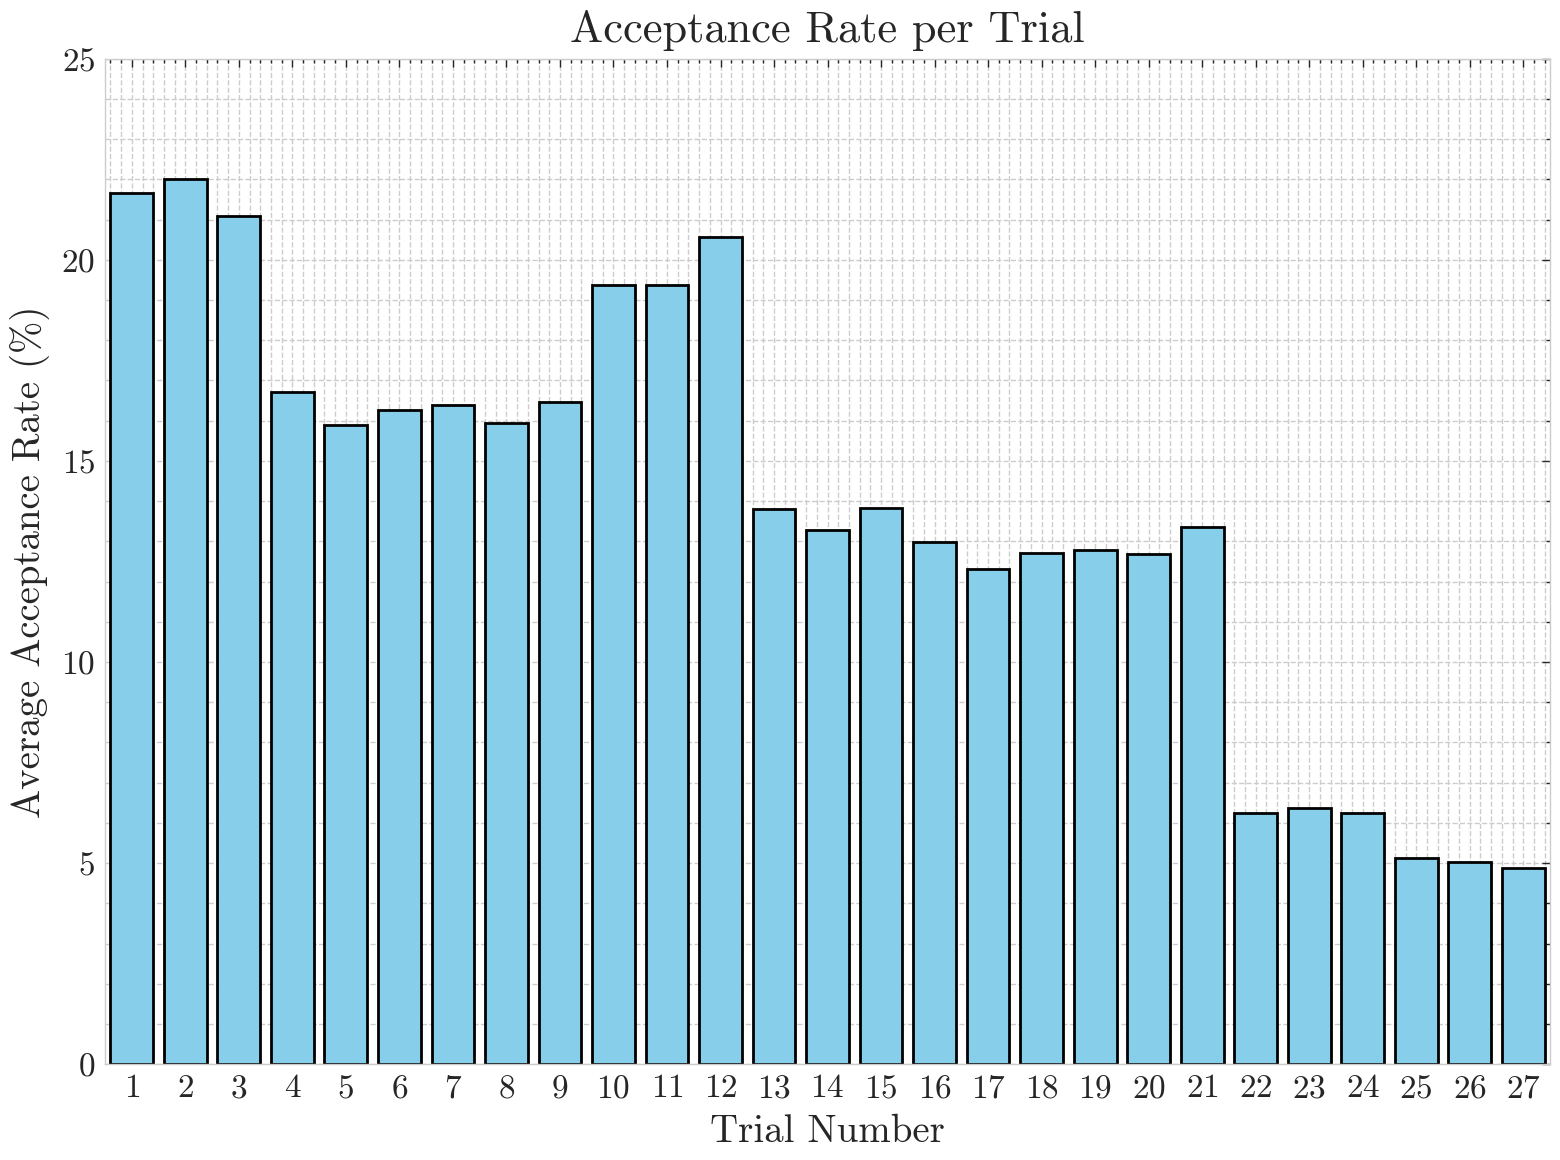

In [118]:
import scienceplots


plt.style.use(['science', 'no-latex'])

plt.figure(figsize=(8,6))
plt.bar(results_df['trial'], results_df['avg_alpha']*100,
        width=0.8, color='skyblue', edgecolor='black')
plt.ylim(0,25)
plt.xlim([0.5,len(results_df)+0.5])
plt.xlabel('Trial Number')
plt.ylabel('Average Acceptance Rate (%)')
plt.title('Acceptance Rate per Trial')
plt.xticks(np.linspace(1,27,27))
plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)


plt.tight_layout()

plt.show()


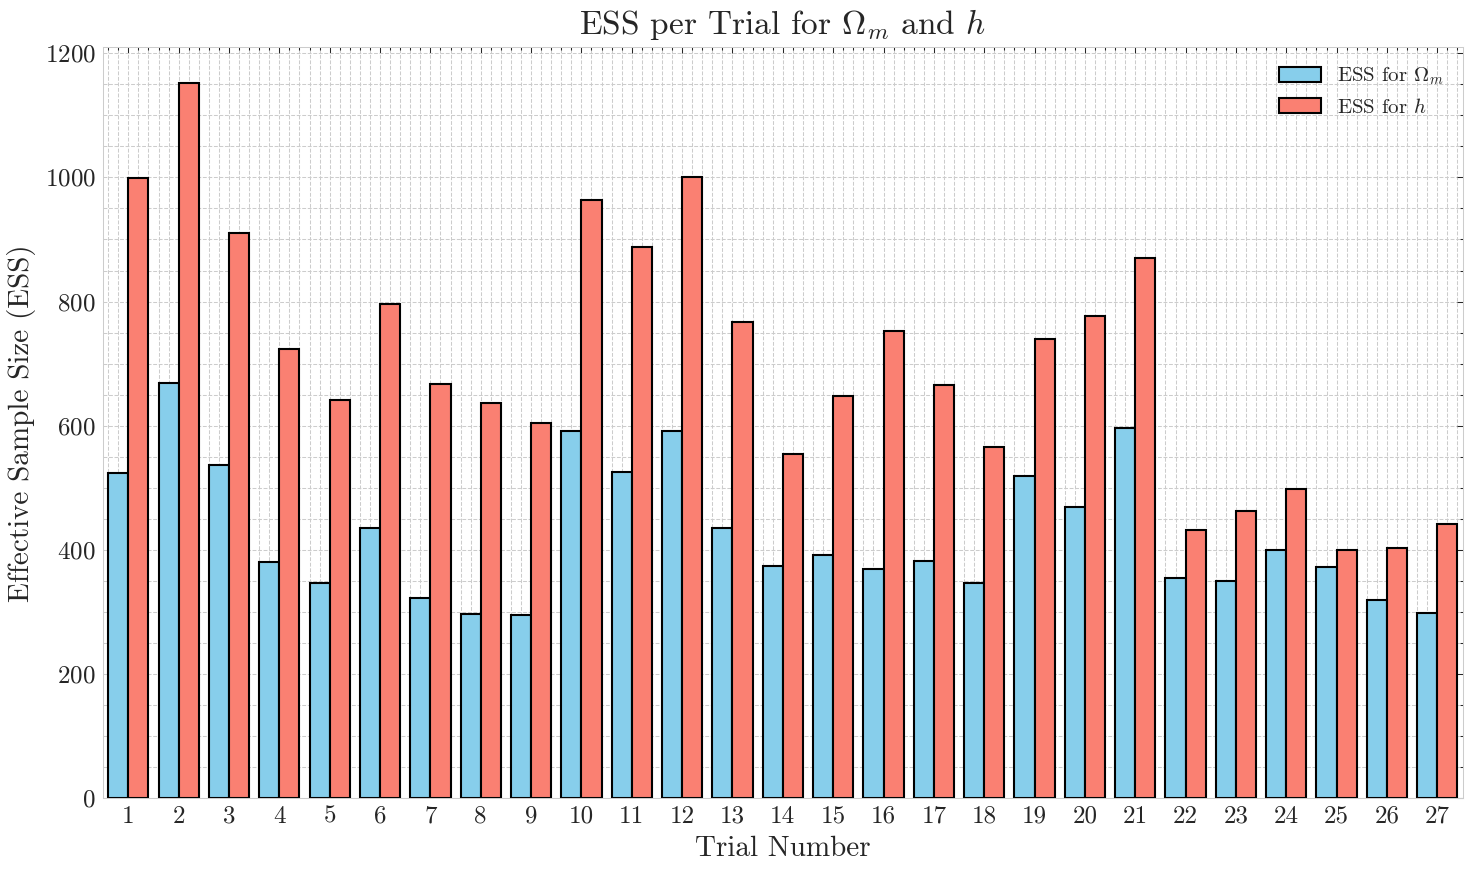

In [117]:
#plot for ess for omega m and h

plt.style.use(['science', 'no-latex'])
n_trials = len(results_df)

plt.figure(figsize=(10,6), dpi=150)

width = 0.4

# Use the trial column as the baseline x positions:
x_positions = results_df['trial']

# Plot bars for ESS of omega_m (shifted left by width/2)
plt.bar(x_positions - width/2, results_df['ess_omega'],
        width=width, color='skyblue', edgecolor='black',
        label='ESS for $\\Omega_m$')

# Plot bars for ESS of h (shifted right by width/2)
plt.bar(x_positions + width/2, results_df['ess_h'],
        width=width, color='salmon', edgecolor='black',
        label='ESS for $h$')

plt.xlim([0.5, n_trials + 0.5])


plt.xticks(x_positions, x_positions)

plt.xlabel("Trial Number")
plt.ylabel("Effective Sample Size (ESS)")
plt.title("ESS per Trial for $\\Omega_m$ and $h$")
plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)

plt.legend()

plt.tight_layout()
plt.show()


* Best looking Trials are: 1, 2, 12
* Make sure they converged using GR diagnostic
* Find out what they used
* Plotting the covariances and step sizes

In [125]:
#Getting stats for each
trial_1 = results_df.iloc[0]
trial_2 = results_df.iloc[1]
trial_12 = results_df.iloc[11]

for i in [0, 1, 11]:
    row = results_df.iloc[i]
    print(f"Trial {row['trial']}:")
    print(f"  Step Size: {row['step_size']}")
    print(f"  Update Interval: {row['update_interval']}")
    print(f"  Learning Rate: {row['learning_rate']}")
    print(f"  Average Acceptance Rate (avg_alpha): {row['avg_alpha']:.4f}")
    print(f"  ESS for Omega_m: {row['ess_omega']:.2f}")
    print(f"  ESS for h: {row['ess_h']:.2f}")


Trial 1:
  Step Size: [0.01, 0.01]
  Update Interval: 100
  Learning Rate: 0.01
  Average Acceptance Rate (avg_alpha): 0.2165
  ESS for Omega_m: 523.84
  ESS for h: 999.42
Trial 2:
  Step Size: [0.01, 0.01]
  Update Interval: 100
  Learning Rate: 0.05
  Average Acceptance Rate (avg_alpha): 0.2200
  ESS for Omega_m: 668.55
  ESS for h: 1152.33
Trial 12:
  Step Size: [0.02, 0.02]
  Update Interval: 100
  Learning Rate: 0.1
  Average Acceptance Rate (avg_alpha): 0.2055
  ESS for Omega_m: 591.41
  ESS for h: 999.84


Plotting step size history of each

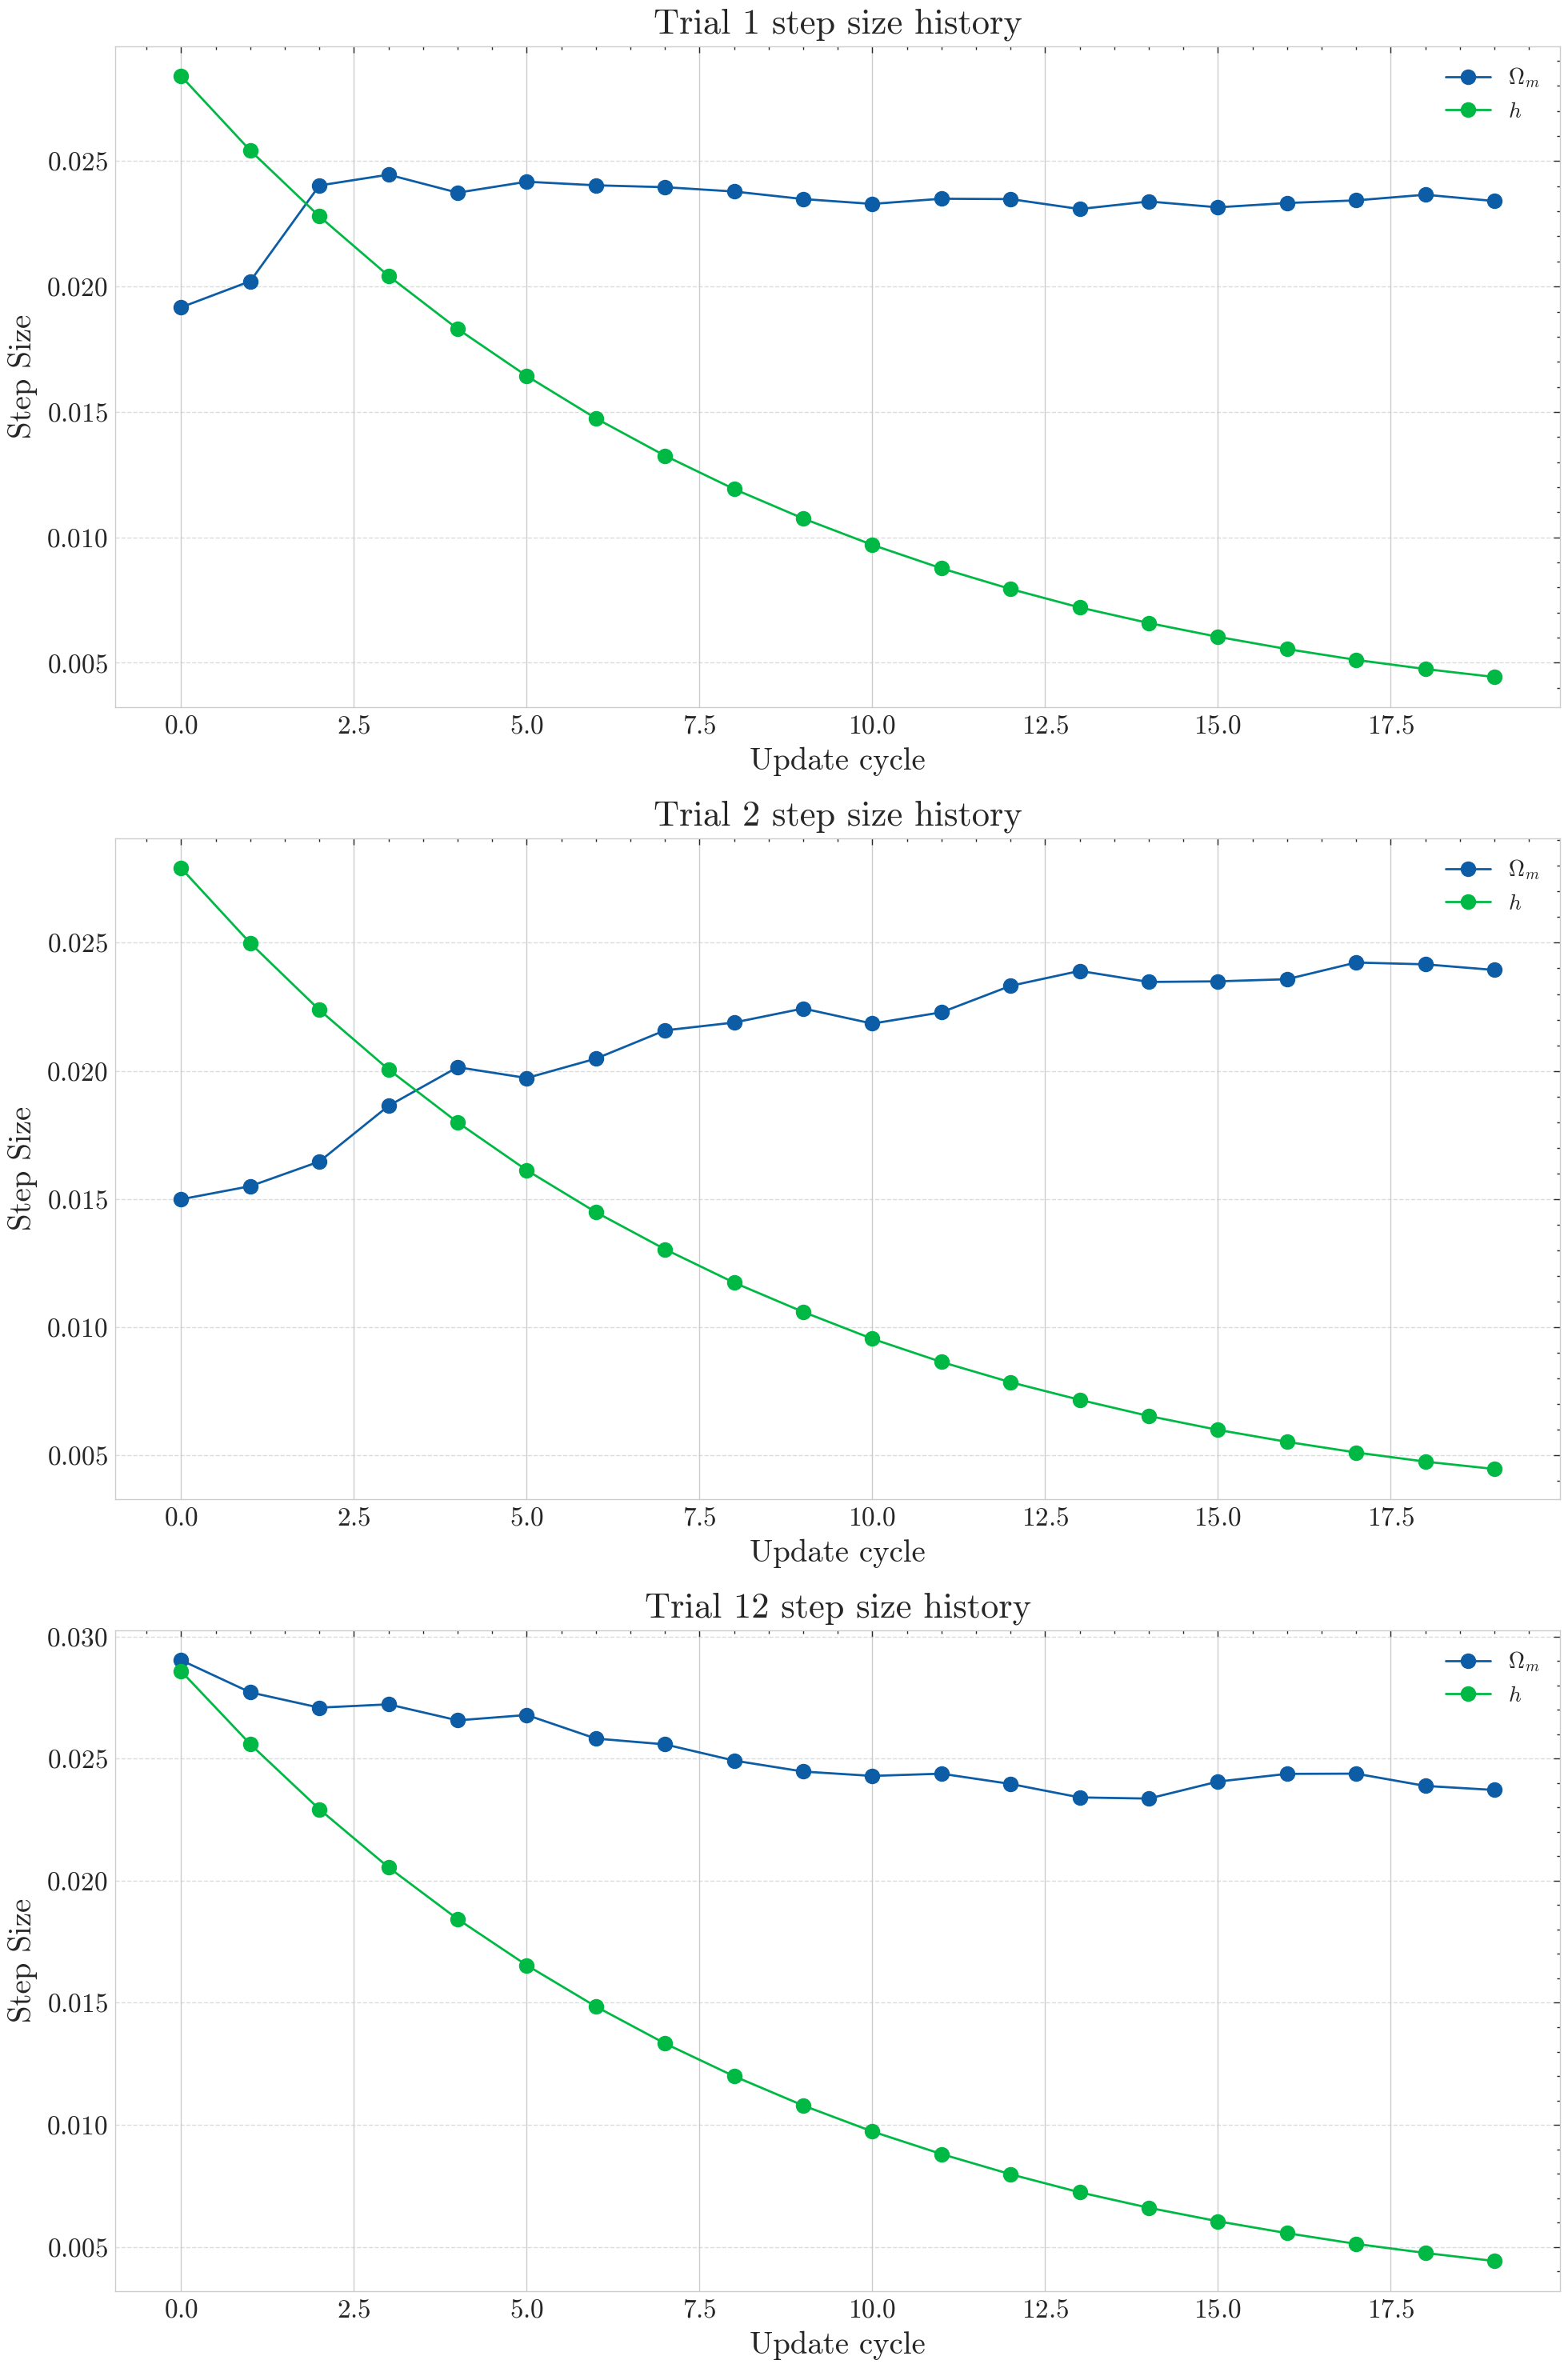

In [145]:
#subplot of all the things
step_hist1 = np.array(results_df.iloc[0]['step_hist'])
step_hist2 = np.array(results_df.iloc[1]['step_hist'])
step_hist12 = np.array(results_df.iloc[11]['step_hist'])

plt.figure(figsize=(10,15))

plt.subplot(3,1,1)
plt.plot(step_hist1[:,0], label = '$\Omega_m$', marker='o')
plt.plot(step_hist1[:,1], label = '$h$', marker='o')
plt.xlabel('Update cycle')
plt.ylabel('Step Size')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Trial 1 step size history')
plt.legend()

plt.subplot(3,1,2)
plt.plot(step_hist2[:,0], label = '$\Omega_m$', marker='o')
plt.plot(step_hist2[:,1], label = '$h$', marker='o')
plt.xlabel('Update cycle')
plt.ylabel('Step Size')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Trial 2 step size history')
plt.legend()


plt.subplot(3,1,3)
plt.plot(step_hist12[:,0], label = '$\Omega_m$', marker='o')
plt.plot(step_hist12[:,1], label = '$h$', marker='o')
plt.xlabel('Update cycle')
plt.ylabel('Step Size')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Trial 12 step size history')
plt.legend()

plt.tight_layout()
plt.show()

#in retrospect i shouldve for looped that mayeb

Step size history is looking normal for all so i wi